In [1]:
# Importing necessary libraries
import re
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

## Building Dataset


In [2]:
data = open('pride_and_prejudice.txt', 'r', encoding='utf-8-sig').read() # Reading the .txt file

In [3]:
text = re.sub('\n+', '\n', data) # Removes multiple consecutive newline characters and replaces them with a single newline character
text = re.sub('\s+', ' ', text) # Removes multiple consecutive whitespace characters and replaces them with a single space character
sentences_list = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text) # Splits the text into a list of sentences based on specific punctuation marks

In [4]:
print(sentences_list[0])

This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever.


In [5]:
# Run this cell only once and then comment it
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
sentences = [word_tokenize(sentence) for sentence in sentences_list] # Tokenize each sentence in the 'sentences_list' list and create a list of tokenized sentences

In [7]:
print(sentences[0])

['This', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'United', 'States', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '.']


In [8]:
total_words = [word for sentence in sentences for word in sentence ]# Creating list of all the words present in data
words = list(set(total_words)) # Remove duplicate words by creating a set and then converting it back to a list
words = words + ['<S>'] +['<E>'] # Adding special tokens
vocab_size = len(words)
vocab_size

8577

In [9]:
# Mapping from word to integers and vice-versa
wtoi = {s:i for i,s in enumerate(words)}
itow = {i:s for s,i in wtoi.items()}

In [10]:
# Creating the train, test and val dataset
def build_dataset(sentences):
    X, Y = [], []
    i = 0
    for sentence in sentences:
        sentence = ['<S>'] + sentence + ['<E>']
        for word1, word2 in zip(sentence, sentence[1:]):
            X.append(wtoi[word1])
            Y.append(wtoi[word2])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(sentences)

print(f'Train data shape : X.shape = {X.shape}, Y.shape = {Y.shape}')

Train data shape : X.shape = torch.Size([159686]), Y.shape = torch.Size([159686])


# **MODEL**

In [11]:
# Creating the model
class BiGramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.W = nn.Linear(vocab_size, vocab_size, bias=False)

    def forward(self, x):
        x = F.one_hot(x, num_classes=vocab_size).float()
        out = self.W(x)
        return out

model = BiGramLanguageModel()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters in the model: {total_params}')

Total parameters in the model: 73564929


In [12]:
# Creating the model
class BiGramLanguageModel_(nn.Module):

    def __init__(self):
        super().__init__()
        self.C = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x):
        out = self.C(x)
        return out

model_ = BiGramLanguageModel_()
total_params = sum(p.numel() for p in model_.parameters() if p.requires_grad)
print(f'Total parameters in the model_: {total_params}')

Total parameters in the model_: 73564929


In [13]:
# Seeting up optimizer and loss
optimizer = torch.optim.SGD(model.parameters(), lr=50)
criterion = nn.CrossEntropyLoss()

In [14]:
# Move model and data to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X, Y = X.to(device), Y.to(device)

## Training

In [15]:
# Training loop
batch_size = 512
lossi = []
n_epochs = 200

for epoch in range(n_epochs):
    indices = list(range(len(X)))
    random.shuffle(indices)
    epoch_loss = 0.0

    for start in range(0, len(X), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]

        batch_X = X[batch_indices]
        batch_Y = Y[batch_indices]

        logits = model(batch_X)
        loss = criterion(logits, batch_Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lr = 50 if epoch < 100 else 25
        # Update the learning rate in the optimizer
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr

        epoch_loss += loss.item()  # Accumulate the batch loss
    average_loss = epoch_loss / (len(X) / batch_size)
    lossi.append(average_loss)

    print(f'{epoch + 1:2d}/{n_epochs:2d} : Average Loss: {average_loss:.4f}')

 1/200 : Average Loss: 7.6254
 2/200 : Average Loss: 6.8023
 3/200 : Average Loss: 6.4384
 4/200 : Average Loss: 6.1903
 5/200 : Average Loss: 6.0003
 6/200 : Average Loss: 5.8453
 7/200 : Average Loss: 5.7140
 8/200 : Average Loss: 5.6012
 9/200 : Average Loss: 5.5006
10/200 : Average Loss: 5.4107
11/200 : Average Loss: 5.3299
12/200 : Average Loss: 5.2556
13/200 : Average Loss: 5.1869
14/200 : Average Loss: 5.1233
15/200 : Average Loss: 5.0639
16/200 : Average Loss: 5.0082
17/200 : Average Loss: 4.9556
18/200 : Average Loss: 4.9060
19/200 : Average Loss: 4.8589
20/200 : Average Loss: 4.8141
21/200 : Average Loss: 4.7715
22/200 : Average Loss: 4.7309
23/200 : Average Loss: 4.6917
24/200 : Average Loss: 4.6546
25/200 : Average Loss: 4.6188
26/200 : Average Loss: 4.5847
27/200 : Average Loss: 4.5516
28/200 : Average Loss: 4.5196
29/200 : Average Loss: 4.4890
30/200 : Average Loss: 4.4594
31/200 : Average Loss: 4.4309
32/200 : Average Loss: 4.4032
33/200 : Average Loss: 4.3764
34/200 : A

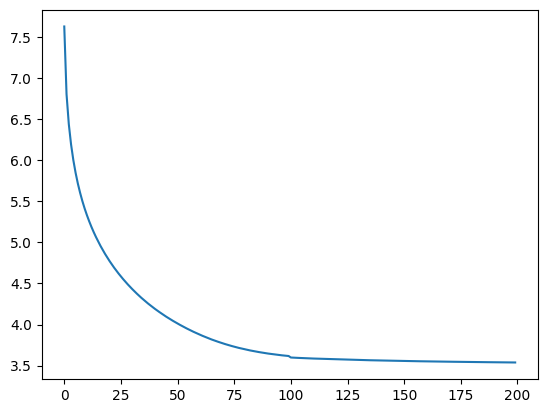

In [16]:
plt.plot(lossi)

## Sampling

In [17]:
# Sampling from the model
g = torch.Generator(device=device).manual_seed(2147483647)

for i in range(5):
    out = []
    ix = wtoi['<S>']
    while True:
        ix = torch.tensor(ix)
        ix = ix.to(device)
        logits = model(ix)
        p = F.softmax(logits, dim=0)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itow[ix])

        if ix==wtoi['<E>']:
            break
    print(' '.join(out))


We never forget , but I had always long as well when they went to meet us , she added , therefore , as will go yourself. ” “ A thousand pounds. ” He was shortly give mountains ? ’ s astonishment at the whole to be good journey was a melancholy scene to observe roasted Monday endurable to marry her little wilderness on good luck , or anything I solicit accounts nerves . <E>
But mere trifle with an uniform cheerfulness began to heighten her intended to think it might change _them_ he began the dining-room they had given by ill of Jane , whither he , “ I might say against him at home -- where your hope your ministers and such sweet girl , since I always so , as to me hear how _Mrs . <E>
He has neither integrity or four o ’ s performance on her master and frequently were all ; and then withdrew to know who , without bribery splendour , though expressed pollution which gave them to discourage him. ” And is grown up , is fortune and Mr. Gardiner . <E>
“ My dear ? <E>
When they were summoned 